In [12]:
'''This code shows the comparison between Hex GKP and tri-symmetry SSV states,
as well as providing more examples of homodyne detection after combing the SSV states.'''

import cmath, random, numpy
import functools
import  matplotlib.pyplot as plt
import sys
import os
import math
from qutip import*

from sympy import*
#from sympsi import*
from scipy import optimize

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time
import math
from qutip import *
from qutip.ipynbtools import plot_animation
import numpy as np
import matplotlib.pyplot as plt
import qutip
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from IPython.display import display, Math, Latex
import cmath
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.special import factorial as fac


In [13]:
#Plotting parameters to be used later
xvec = np.arange(-40.,40.)*5./40
yvec = np.arange(-50.,50)*5/40
X,Y = np.meshgrid(xvec, xvec)  ##Some plotting params
X1,Y1 = np.meshgrid(yvec,yvec)
N_dim = 20##Dimenstion of the Hilbert spac

a1 = destroy(N_dim) ##This is for single-photon field
a2 = destroy(N_dim) ##for coherent field
a3 = destroy(N_dim) ##for vacuum field
def n_choose_k(n,k):
    return fac(n)/(fac(n-k)*fac(k))
def D(state,alpha):
    Rho_new=displace(N_dim,alpha)*state*displace(N_dim,alpha).dag()
    return Rho_new   
'''Define a rotation in phase space, or phase shifter operation'''
def Phase(theta):
    b=-1j*theta*a1.dag()*a1;
    return b.expm()
'''Squeezing operation, inputs a density matrix and outputs the squeezed density matrix for squeezing parameter r'''
def Sq(state,r):
    Rho_new=squeeze(N_dim,r)*state*squeeze(N_dim,r).dag();
    return Rho_new
'''The function below creates a beamsplitter operation that acts on two modes.  
The value for k determines what number Fock state could be filtered out of the first state
based on a single photon input for the second BS port, followed by single photon detection.'''
def BS_operator_filtering(a1, a2, k):
    theta_k = np.arctan(1/np.sqrt(k))
    T = np.sin(theta_k)*np.sin(theta_k)
    R = np.cos(theta_k)*np.cos(theta_k)
    print('I am filtering', k, 'and:', theta_k*180/math.pi)
    print('BS T is : ', T, 'and : ', R)
    b = theta_k*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))
    return b.expm()
def sq_tri_cat(r,amp):
    state=ket2dm((displace(N_dim,amp)*squeeze(N_dim,r)*fock(N_dim,0)+displace(N_dim,amp*np.e**(2j*np.pi/3))*squeeze(N_dim,r*np.e**(4j*np.pi/3))*fock(N_dim,0)+displace(N_dim,amp*np.e**(4j*np.pi/3))*squeeze(N_dim,r*np.e**(2j*np.pi/3))*fock(N_dim,0)))
    norm_state=state/state.tr()
    return norm_state
def SSV_plus(r,alpha):
    state = ket2dm((displace(N_dim,alpha)+displace(N_dim,-alpha))*squeeze(N_dim,r)*fock(N_dim,0))
    norm_state = state/state.tr()
    return norm_state
def SSV_minus(r,alpha):
    state = ket2dm((displace(N_dim,alpha)-displace(N_dim,-alpha))*squeeze(N_dim,r)*fock(N_dim,0))
    norm_state = state/state.tr()
    return norm_state
def cat_plus(alpha):
    cat = (1/(np.sqrt(2)*np.sqrt(1+np.e**(-alpha*alpha.conj()))))*(coherent(N_dim,-alpha)+(coherent(N_dim,alpha)))
    return cat
def cat_minus(alpha):
    cat = (1/(np.sqrt(2)*np.sqrt(1-np.e**(-alpha*alpha.conj()))))*(-coherent(N_dim,-alpha)+(coherent(N_dim,alpha)))
    return cat
def pnr_resolution_detector(eta, click, n_truc):
    pi_n = 0;
    l = np.arange(click,n_truc)
    for i in l:
        pi_n +=  n_choose_k(i,click)*math.pow((1-eta),(i-click))*math.pow(eta,click)*fock(N_dim,i)*fock(N_dim,i).dag()
        #print("The final Povm element is: ", pi_0)
    return Qobj(pi_n)
def Fock_Filter_povm(in_state,in_fock,refl,num_det,eta,n_truc):
    Projector = tensor(pnr_resolution_detector(eta, num_det, n_truc),qeye(N_dim));
    Initial_state=tensor(in_state,ket2dm(fock(N_dim,in_fock)));
    theta_k=np.arccos(np.sqrt(refl));
    
    BS1= ((theta_k)*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))).expm()
        
    Rho=BS1*Initial_state*BS1.dag();
        
    Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr())
    '''The operation .ptrace(m) takes the partial trace over every mode EXCEPT m, where the numbering 
    startes at 0.  So .ptrace(1) means you keep mode 1, which is actually the 2nd mode'''
    print('BS has reflectivity',refl,' and I am detecting the |',num,'> state, where my detector has efficiency', eta)
    return Rho_filtered
def Fock_Filter_prob(in_state,in_fock,refl,num_det,eta,n_truc):
    Projector = tensor(pnr_resolution_detector(eta, num_det, n_truc),qeye(N_dim));
    Initial_state=tensor(in_state,ket2dm(fock(N_dim,in_fock)));
    theta_k=np.arccos(np.sqrt(refl));
    
    BS1= ((theta_k)*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))).expm()
        
    Rho=BS1*Initial_state*BS1.dag();
    P=(Rho*Projector).tr()
    print('The probability of a sucessful detection is:',P)    
    Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr())
    #Rho_filtered=Rho*Projector
    '''The operation .ptrace(m) takes the partial trace over every mode EXCEPT m, where the numbering 
    startes at 0.  So .ptrace(1) means you keep mode 1, which is actually the 2nd mode'''
    print('BS has reflectivity',refl,' and I am detecting the |',num,'> state, where my detector has efficiency', eta)
    return Rho_filtered
def catalysis(in1,in2,refl,num_det,eta,n_truc):
    Projector = tensor(pnr_resolution_detector(eta, num_det, n_truc),qeye(N_dim));
    Initial_state=tensor(in1,in2);
    theta_k=np.arccos(np.sqrt(refl));
    
    BS1= ((theta_k)*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))).expm()
        
    Rho=BS1*Initial_state*BS1.dag();
    
    P=(Rho*Projector).tr()
    print('The probability of a sucessful detection is:',P)   
    
    Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr())
    '''The operation .ptrace(m) takes the partial trace over every mode EXCEPT m, where the numbering 
    startes at 0.  So .ptrace(1) means you keep mode 1, which is actually the 2nd mode'''
    print('BS has reflectivity',refl,' and I am detecting the |',num,'> state, where my detector has efficiency', eta)
    return Rho_filtered

def fid(state1,state2):
    F=np.absolute((state1.sqrtm()*state2*state1.sqrtm()).sqrtm().tr())
    return F


In [14]:
###Re-derived the hex_GKP and made sure.  Made a couple of small modifications, but my code now works too!
def my_hex_GKP(mu, d, delta, cutoff, nmax=400):
    r"""Hexagonal GKP code state.
    The Hex GKP state is defined by
    .. math::
        |mu> = \sum_{n_1,n_2=-\infty}^\infty e^{-i(q+\sqrt{3}p)/2}
            \sqrt{4\pi/\sqrt{3}d}(dn_1+\mu) e^{iq\sqrt{4\pi/\sqrt{3}d}n_2}|0>
    where d is the dimension of a code space, \mu=0,1,...,d-1, |0> is the
    vacuum state, and the states are modulated by a Gaussian envelope in the
    case of finite energy:
    ..math:: e^{-\Delta ^2 n}|\mu>
    Args:
        d (int): the dimension of the code space.
        mu (int): mu=0,1,...,d-1.
        delta (float): width of the modulating Gaussian envelope.
        cutoff (int): the Fock basis truncation of the returned state vector.
        nmax (int): the Hex GKP state |mu> is calculated by performing the
            sum using n1,n1=-nmax,...,nmax.
    Returns:
        array: a size [cutoff] complex array state vector.
    """
    n1 = np.arange(-nmax, nmax+1)[:, None]
    n2 = np.arange(-nmax, nmax+1)[None, :]

    n1sq = n1**2
    n2sq = n2**2

    sqrt3 = np.sqrt(3)

    #arg1 = -1j*np.pi*n2*(d*n1+mu)/d
    arg1 = -1j*np.pi*n2*(d*n1+mu)/d
    arg2 = -np.pi*(d**2*n1sq+n2sq-d*n1*(n2-2*mu)-n2*mu+mu**2)/(sqrt3*d)
    arg2 *= 1-np.exp(-2*delta**2)

    #amplitude = (np.exp(arg1)*np.exp(arg2)).flatten()[:, None]
    amplitude = (np.exp(arg1)).flatten()[:, None]


    alpha = np.sqrt(np.pi/(2*sqrt3*d)) * (sqrt3*(d*n1+mu) - 1j*(d*n1-2*n2+mu))
    #alpha *= np.exp(-delta**2)

    alpha = alpha.flatten()[:, None]
    n = np.arange(cutoff)[None, :]
    coherent = np.exp(-0.5*np.abs(alpha)**2)*alpha**n/np.sqrt(fac(n))
    
    #hex_state = np.sum(amplitude*coherent*np.exp(-n*delta**2), axis=0)
    hex_state = ket2dm(Qobj(np.sum(amplitude*coherent*np.exp(-n*delta**2), axis=0)))
    final=hex_state/hex_state.tr()
    return final

In [8]:
refl1= .576813**2; refl2=0.54398**2; refl3=0.55;refl4=0.42134**2;
delta=4.8772; beta=2.26; sq=0.476595; alpha=1.59; n1=6;n2=4;n3=2;n4=1
eta=1;

first=Fock_Filter_prob(ket2dm(coherent(N_dim,delta)),1,refl1,n1,eta,N_dim)
W1=wigner(first,yvec,yvec);
second=Fock_Filter_prob(first,1,refl2,n2,eta,N_dim);
W2=wigner(second,yvec,yvec);
third=Fock_Filter_prob(second,1,refl3,n3,eta,N_dim);
W3=wigner(third,yvec,yvec);
catalyzed=D(third,-beta);
W_tri=wigner(catalyzed,xvec,xvec);

approx_hex=catalysis(catalyzed,Phase(np.pi/3)*catalyzed*Phase(np.pi/3).dag(),1/2,0,eta,N_dim)
W_approx=wigner(approx_hex,xvec,xvec)

The probability of a sucessful detection is: 0.08125622285789687
BS has reflectivity 0.332713236969  and I am detecting the | <function num at 0x0000020416110048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.11588192440241311
BS has reflectivity 0.29591424040000003  and I am detecting the | <function num at 0x0000020416110048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.008415971050254392
BS has reflectivity 0.55  and I am detecting the | <function num at 0x0000020416110048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.29907192387838666
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000020416110048> > state, where my detector has efficiency 1


Text(0.5,0.92,'mixture gkp ')

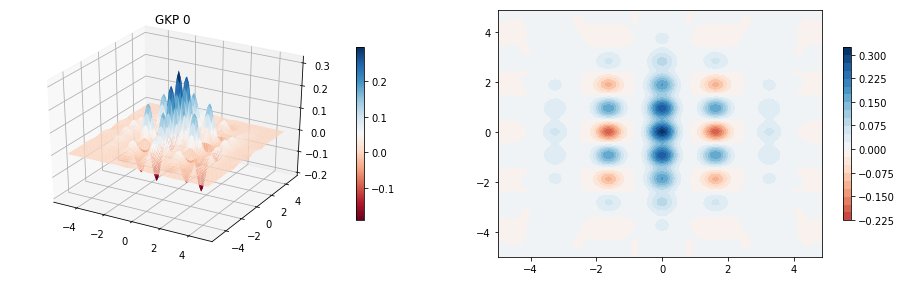

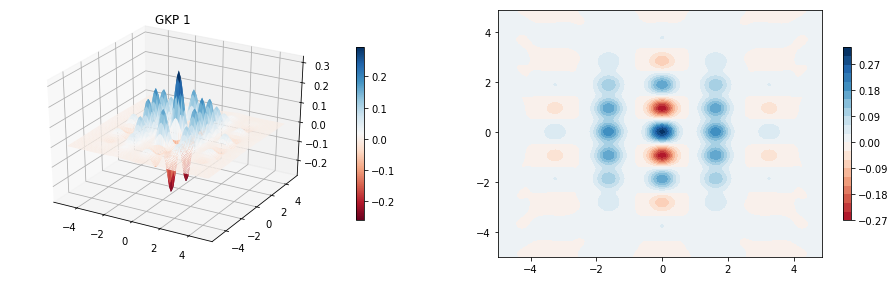

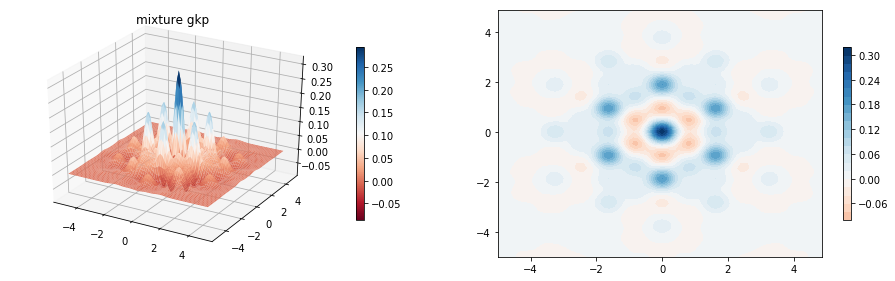

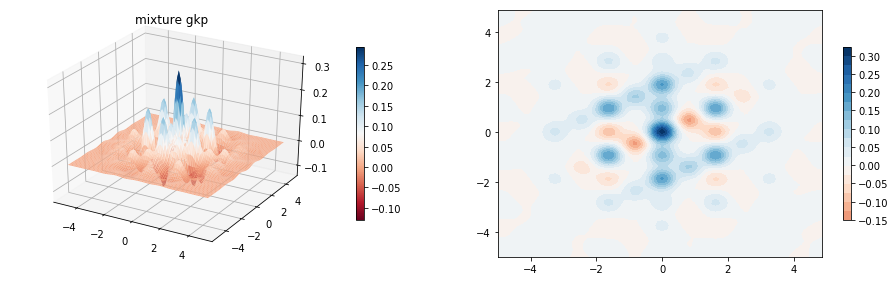

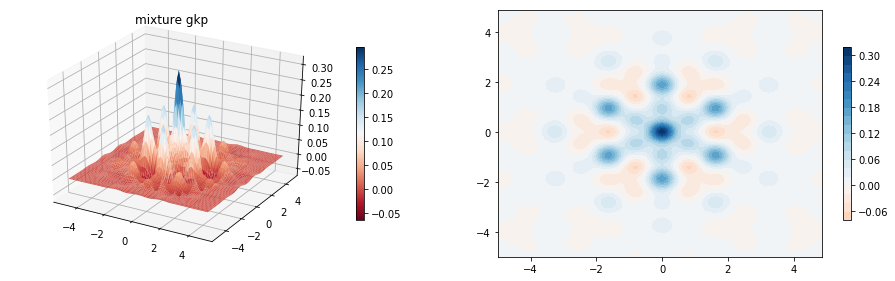

In [5]:
code_d=2
hex_gkp0=my_hex_GKP(0,code_d,0.4,35)
hex_gkp1=my_hex_GKP(1,code_d,0.4,35)
hex_gkp_mix1=(hex_gkp1+Phase(np.pi/3)*hex_gkp1*Phase(np.pi/3).dag()+Phase(2*np.pi/3)*hex_gkp1*Phase(2*np.pi/3).dag())
hex_gkp_mix2=(hex_gkp0+Phase(np.pi/3)*hex_gkp1*Phase(np.pi/3).dag())
hex_gkp_mix3=(hex_gkp0+Phase(np.pi/3)*hex_gkp0*Phase(np.pi/3).dag()+Phase(2*np.pi/3)*hex_gkp0*Phase(2*np.pi/3).dag())


W_hex_mix1=wigner(hex_gkp_mix1/hex_gkp_mix1.tr(),xvec,xvec)
W_hex_mix2=wigner(hex_gkp_mix2/hex_gkp_mix2.tr(),xvec,xvec)
W_hex_mix3=wigner(hex_gkp_mix3/hex_gkp_mix3.tr(),xvec,xvec)
W_hex0=wigner(hex_gkp0,xvec,xvec)
W_hex1=wigner(hex_gkp1,xvec,xvec)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_hex0, 20, cmap=cm.RdBu, vmin=-1/np.pi, vmax=1/np.pi)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_hex0, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('GKP 0')

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_hex1, 20, cmap=cm.RdBu, vmin=-1/np.pi, vmax=1/np.pi)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_hex1, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('GKP 1')

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_hex_mix1, 20, cmap=cm.RdBu, vmin=-1/np.pi, vmax=1/np.pi)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_hex_mix1, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('mixture gkp')

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_hex_mix2, 20, cmap=cm.RdBu, vmin=-1/np.pi, vmax=1/np.pi)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_hex_mix2, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('mixture gkp ')

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_hex_mix3, 20, cmap=cm.RdBu, vmin=-1/np.pi, vmax=1/np.pi)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_hex_mix3, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('mixture gkp ')

The probability of a sucessful detection is: 0.3067749706335233
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000020416110048> > state, where my detector has efficiency 1
fidelity of approx with gkp: 0.7732745564995899
fidelity of exact catalyzed tri with gkp: 0.78930774213455


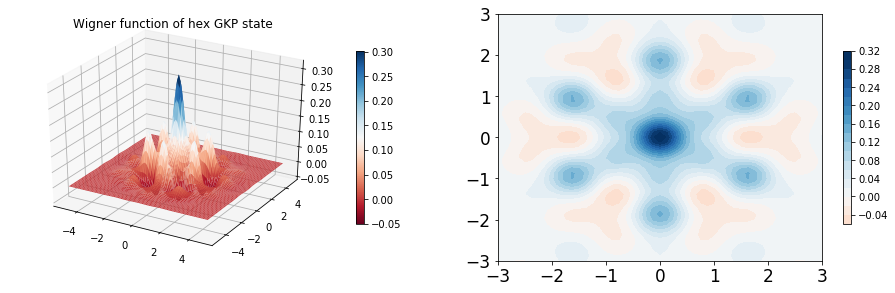

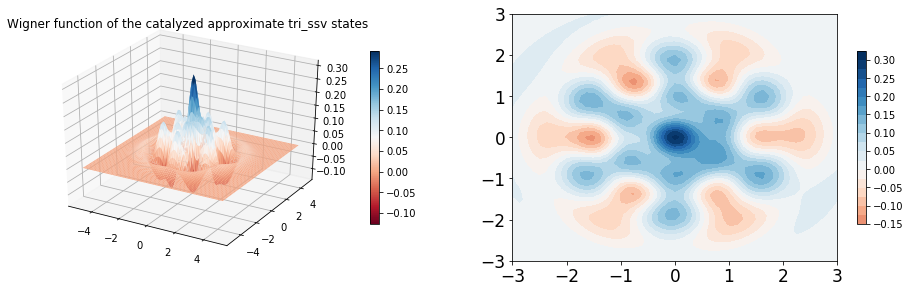

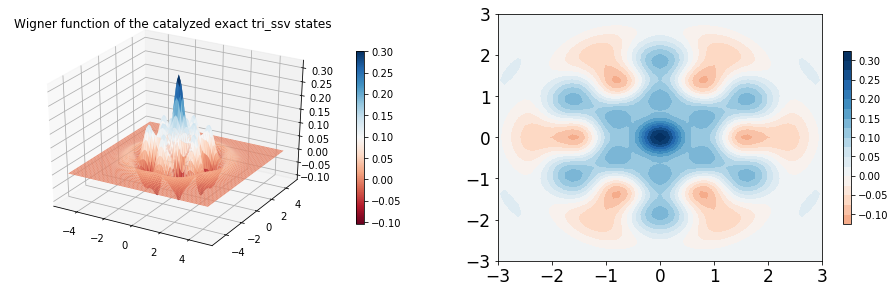

In [17]:
code_d=2
hex_gkp0=my_hex_GKP(0,code_d,0.46,35)
narrow_hex=my_hex_GKP(0,code_d,0.2,35)
narrow_comb=(narrow_hex+Phase(np.pi/3)*narrow_hex*Phase(np.pi/3).dag()+Phase(2*np.pi/3)*narrow_hex*Phase(2*np.pi/3).dag())
narrow_state=narrow_comb/narrow_comb.tr()
W_narrow_hex=wigner(narrow_state,xvec,xvec)

hex_comb=(hex_gkp0+Phase(np.pi/3)*hex_gkp0*Phase(np.pi/3).dag()+Phase(2*np.pi/3)*hex_gkp0*Phase(2*np.pi/3).dag())
hex_state=hex_comb/hex_comb.tr()

amp=1.255
sq=.24

tri_ssv=sq_tri_cat(sq,amp);
W_tri=wigner(tri_ssv,xvec,xvec);

catalyzed_tri=catalysis(tri_ssv,Phase(np.pi/3)*tri_ssv*Phase(np.pi/3).dag(),1/2,0,eta,N_dim)
W_catalyzed_tri=wigner(catalyzed_tri,xvec,xvec);
W_hexgkp=wigner(hex_state,xvec,xvec)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_hexgkp, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_hexgkp, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of hex GKP state')
fid1=fidelity(approx_hex,hex_state)
print('fidelity of approx with gkp:',fid1**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_approx, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_approx, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of the catalyzed approximate tri_ssv states')

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_catalyzed_tri, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_catalyzed_tri, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of the catalyzed exact tri_ssv states')
fid2=fidelity(catalyzed_tri,hex_state)
print('fidelity of exact catalyzed tri with gkp:',fid2**2)


fidelity of approx with gkp: 0.7732745564995899
fidelity of exact catalyzed tri with gkp: 0.78930774213455


Text(0.5,0.92,'Wigner function of hex linear comb with narrow peaks')

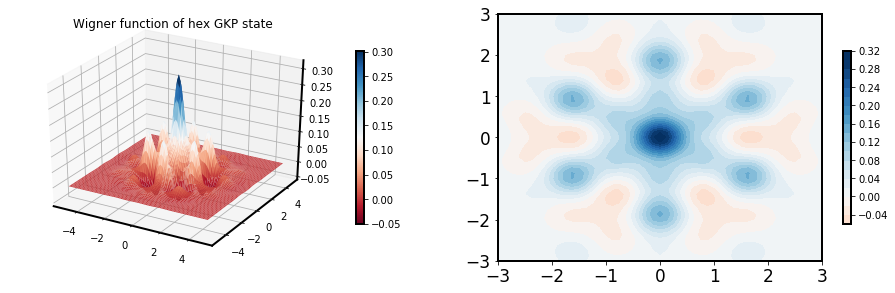

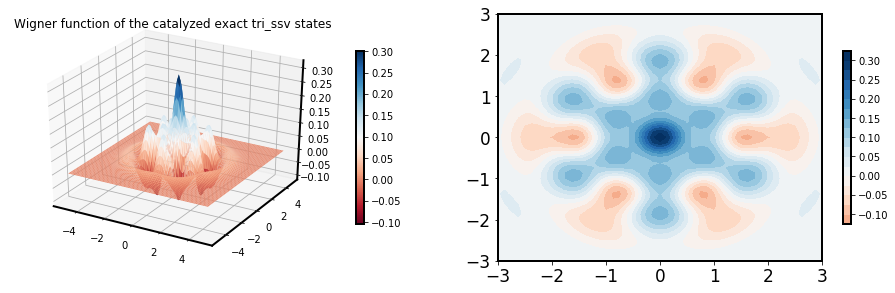

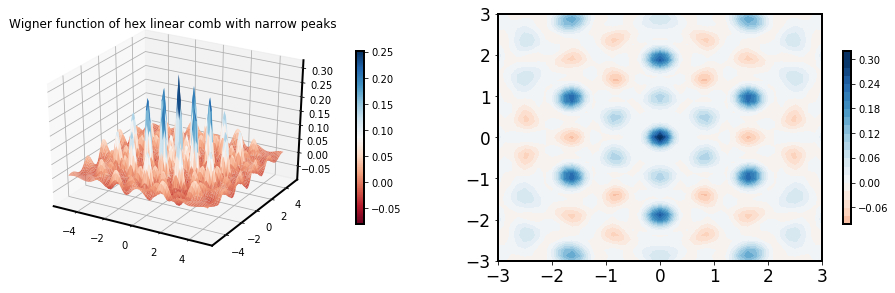

In [18]:
from pylab import *
rc('axes', linewidth=2)
fontsize=14

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_hexgkp, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_hexgkp, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of hex GKP state')
fid1=fidelity(approx_hex,hex_state)
print('fidelity of approx with gkp:',fid1**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_catalyzed_tri, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_catalyzed_tri, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of the catalyzed exact tri_ssv states')
fid2=fidelity(catalyzed_tri,hex_state)
print('fidelity of exact catalyzed tri with gkp:',fid2**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_narrow_hex, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_narrow_hex, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of hex linear comb with narrow peaks')


In [15]:
###What does it look like when I send the tri_SSV through Homodyne?
amp=1.255
sq=.24

tri_ssv=sq_tri_cat(sq,amp);

in1=tri_ssv.full()
in2=tri_ssv.full()
import strawberryfields as sf
from strawberryfields.ops import *
import tensorflow as tf
eng, q = sf.Engine(2)
with eng:
    Ket(in1) | q[0]
    Ket(in2) | q[1]
    BSgate()  | (q[0], q[1])
    MeasureHomodyne(np.pi/2,select=0) | q[0]
    #wigner | (q[1].val)
state_final = eng.run('tf', cutoff_dim =20, modes=1, eval=True)
qutip_state=Qobj(state_final.dm())
W_homodyne=wigner(qutip_state,xvec,xvec)

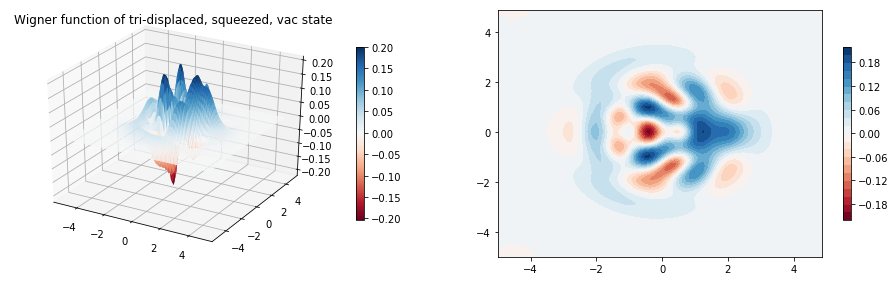

In [16]:
fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_homodyne, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_homodyne, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of tri-displaced, squeezed, vac state')
plt.show()

In [19]:
in1=(Phase(np.pi/3)*tri_ssv*Phase(np.pi/3).dag()).full()
in2=tri_ssv.full()
import strawberryfields as sf
from strawberryfields.ops import *
import tensorflow as tf
eng, q = sf.Engine(2)
with eng:
    Ket(in1) | q[0]
    Ket(in2) | q[1]
    BSgate()  | (q[0], q[1])
    MeasureHomodyne(np.pi/2,select=0) | q[0]
    #wigner | (q[1].val)
state_final2 = eng.run('tf', cutoff_dim =20, modes=1, eval=True)
qutip_state2=Qobj(state_final2.dm())
W_homodyne2=wigner(qutip_state2,xvec,xvec)

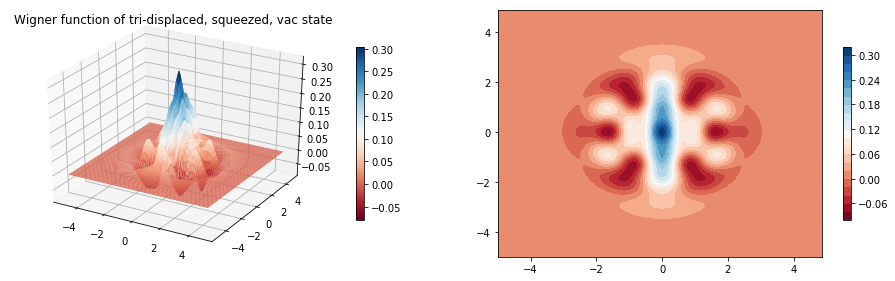

In [20]:
fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_homodyne2, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_homodyne2, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of tri-displaced, squeezed, vac state')
plt.show()

In [21]:
in1=(Phase(np.pi/6)*Phase(np.pi/3)*tri_ssv*Phase(np.pi/3).dag()*Phase(np.pi/6).dag()).full()
in2=(Phase(np.pi/6)*tri_ssv*Phase(np.pi/6).dag()).full()
import strawberryfields as sf
from strawberryfields.ops import *
import tensorflow as tf
eng, q = sf.Engine(2)
with eng:
    Ket(in1) | q[0]
    Ket(in2) | q[1]
    BSgate()  | (q[0], q[1])
    MeasureHomodyne(np.pi/2,select=0) | q[0]
    #wigner | (q[1].val)
state_final3 = eng.run('tf', cutoff_dim =20, modes=1, eval=True)
qutip_state3=Qobj(state_final3.dm())
W_homodyne3=wigner(qutip_state3,xvec,xvec)

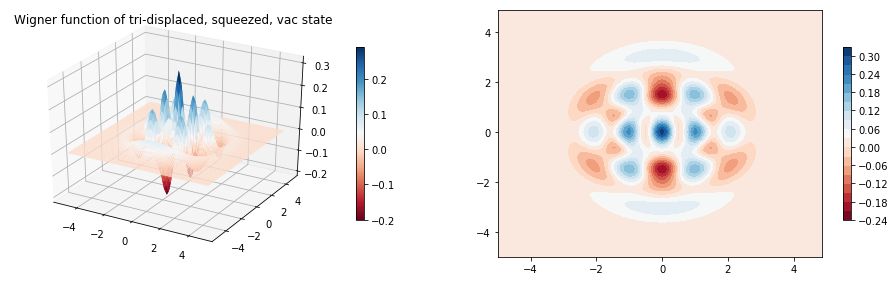

In [22]:
fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_homodyne3, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_homodyne3, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of tri-displaced, squeezed, vac state')
plt.show()